# Benchmarking Read/Write of Geospatial Data Formats
 
Writing large-ish geopackages can take forever with GeoPandas. How do other formats/engines stack up?

Jonathan Markel
3D Geospatial Laboratory  
The University of Texas at Austin  
08/30/2023

##### [Twitter](https://twitter.com/jonm3d) | [GitHub](https://github.com/jonm3d) | [Website](http://j3d.space) | [GoogleScholar](https://scholar.google.com/citations?user=KwxwFgYAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/j-markel/) 

In [16]:
# ! pip install contextily

In [17]:
import os
import timeit
import geopandas as gpd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import contextily as cx

In [27]:
path_to_file = "/home/jovyan/geobench/data/larger.gpkg"
bench_dir = "/home/jovyan/geobench/outputs"

# Load / inspect the dataframe
df = gpd.read_file(path_to_file, engine="pyogrio")

display(df.head())

print(df.shape)

,time,rms_misfit,cycle,distance,rgt,dh_fit_dx,dh_fit_dy,h_sigma,w_surface_window_final,h_mean,pflags,spot,gt,segment_id,n_fit_photons,geometry
0,2020-05-07 20:08:05,0.147654,7,5.302745e+06,646,-0.018934,0.0,0.018907,3.0,729.973337,0,1,60,264442,61,POINT (-119.90488 47.62924)
1,2020-05-07 20:08:05,0.126176,7,5.302765e+06,646,-0.009560,0.0,0.015591,3.0,729.611541,0,1,60,264443,66,POINT (-119.90490 47.62942)
2,2020-05-07 20:08:05,0.129512,7,5.302785e+06,646,-0.017475,0.0,0.016802,3.0,729.319129,0,1,60,264444,60,POINT (-119.90493 47.62960)
3,2020-05-07 20:08:05,0.105586,7,5.302805e+06,646,-0.012948,0.0,0.012806,3.0,729.157888,0,1,60,264445,68,POINT (-119.90496 47.62978)
4,2020-05-07 20:08:05,0.136343,7,5.302825e+06,646,0.005552,0.0,0.015604,3.0,729.079155,0,1,60,264446,78,POINT (-119.90498 47.62996)


(114717, 16)


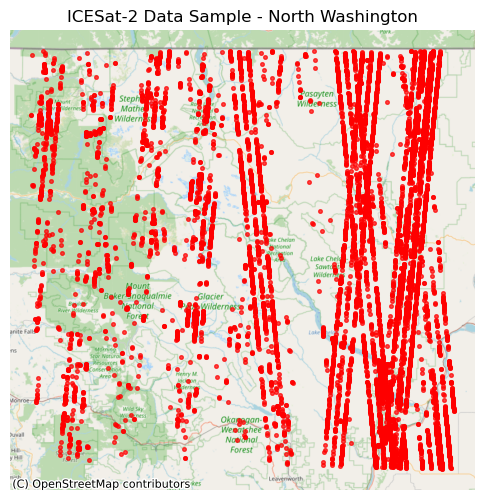

In [40]:
sample_df = df.sample(10000).drop(columns='time').to_crs('epsg:3857')

fig, ax = plt.subplots(figsize=(6,6))
sample_df.plot(ax=ax, color='red', markersize=7, alpha=0.7) 
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('ICESat-2 Data Sample - North Washington')
ax.set_axis_off()

plt.show()

In [3]:
def write_geo_data(df, filename, format, driver, use_pyogrio=True, layer_options=None):
    engine = "pyogrio" if use_pyogrio else None
    gdf_to_save = df.copy()
    
    if 'time' in gdf_to_save.columns:
        gdf_to_save['time'] = gdf_to_save['time'].astype(str)
    
    if format == 'shapefile':
        for col in gdf_to_save.columns:
            if len(col) > 10:
                gdf_to_save.rename(columns={col: col[:10]}, inplace=True)
    
    if format == 'parquet':
        gdf_to_save.to_parquet(os.path.join(bench_dir, filename))
    else:
        gdf_to_save.to_file(os.path.join(bench_dir, filename), driver=driver, engine=engine, layer_options=layer_options)


def read_geo_data(filename, format, use_pyogrio=True):
    engine = "pyogrio" if use_pyogrio else None
    
    if format == 'parquet':
        gdf = gpd.read_parquet(os.path.join(bench_dir, filename))
    else:
        gdf = gpd.read_file(os.path.join(bench_dir, filename), engine=engine)
    
    # Convert string column back to datetime
    if 'time' in gdf.columns:
        gdf['time'] = pd.to_datetime(gdf['time'])
    
    return gdf

In [4]:
number_of_repeats = 10

formats = [
    {'filename': 'test.parquet', 'format': 'parquet', 'driver': None, 'label': 'parquet'},
    {'filename': 'test.gpkg', 'format': 'geopackage', 'driver': 'GPKG', 'label': 'gpkg \n(pyogrio)'},
    {'filename': 'test.gpkg', 'format': 'geopackage', 'driver': 'GPKG', 'label': 'gpkg', 'use_pyogrio': False},
    {'filename': 'test.shp', 'format': 'shapefile', 'driver': 'ESRI Shapefile', 'label': 'shp \n(pyogrio)'},
    {'filename': 'test.shp', 'format': 'shapefile', 'driver': 'ESRI Shapefile', 'label': 'shp', 'use_pyogrio': False},
    
    # {'filename': 'test.fgb', 'format': 'flatgeobuf', 'driver': 'FlatGeobuf', 'label': 'fgb'}
    # {'filename': 'test_noindex.gpkg', 'format': 'geopackage', 'driver': 'GPKG', 'label': 'gpkg \n(no index, pyogrio)', 'layer_options': ["SPATIAL_INDEX=NO"]},
    # {'filename': 'test_noindex.gpkg', 'format': 'geopackage', 'driver': 'GPKG', 'label': 'gpkg \n(no index)', 'use_pyogrio': False, 'layer_options': ["SPATIAL_INDEX=NO"]},
    
]

write_results = []
read_results = []

for fmt in formats:
    print(f"Benchmarking {fmt['label']} write...")
    write_time = timeit.timeit(lambda: write_geo_data(df, fmt['filename'], fmt['format'], fmt['driver'], fmt.get('use_pyogrio', True)), number=number_of_repeats) / number_of_repeats
    print(f"Average write time: {write_time}")
    write_results.append({
        'Format': fmt['label'],
        'Average Write Time (s)': write_time
    })

    print(f"Benchmarking {fmt['label']} read...")
    read_time = timeit.timeit(lambda: read_geo_data(fmt['filename'], fmt['format'], fmt.get('use_pyogrio', True)), number=number_of_repeats) / number_of_repeats
    print(f"Average read time: {read_time}\n")
    read_results.append({
        'Format': fmt['label'],
        'Average Read Time (s)': read_time
    })

write_df = pd.DataFrame(write_results)
read_df = pd.DataFrame(read_results)

combined_df = write_df.merge(read_df, on='Format')
melted_df = combined_df.melt(id_vars=['Format'], value_vars=['Average Write Time (s)', 'Average Read Time (s)'])

# Simplify the variable names for the hue labels
melted_df['variable'] = melted_df['variable'].replace({
    'Average Write Time (s)': 'Write',
    'Average Read Time (s)': 'Read'
})

melted_df = melted_df.sort_values(by='value', ascending=True)  

Benchmarking parquet write...
Average write time: 0.5197290357202291
Benchmarking parquet read...
Average read time: 0.11090886350721121

Benchmarking gpkg 
(pyogrio) write...
Average write time: 11.705841269344091
Benchmarking gpkg 
(pyogrio) read...
Average read time: 1.5119049668312072

Benchmarking gpkg write...
Average write time: 24.163372774422168
Benchmarking gpkg read...
Average read time: 22.60348596274853

Benchmarking shp 
(pyogrio) write...
Average write time: 5.256669400259852
Benchmarking shp 
(pyogrio) read...
Average read time: 1.2143211968243122

Benchmarking shp write...
Average write time: 16.417900232039393
Benchmarking shp read...
Average read time: 22.84613934699446



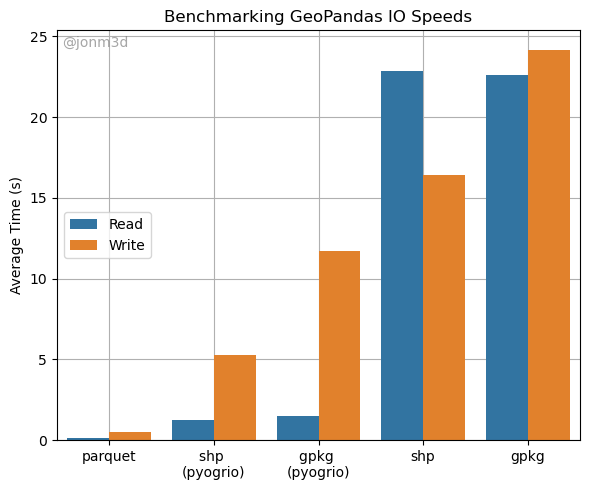

In [8]:
plt.figure(figsize=(6, 5))

sns.barplot(x='Format', y='value', hue='variable', data=melted_df, zorder=2)
plt.xlabel('')
plt.ylabel('Average Time (s)')
plt.title('Benchmarking GeoPandas IO Speeds')
plt.legend(loc='center left')

plt.annotate('@jonm3d',
             xy=(0.01, 0.96), 
             xycoords='axes fraction',
             fontsize=10, 
             alpha=0.7,
             color='grey')

plt.grid(zorder=1)

plt.tight_layout()

plt.savefig(os.path.join(bench_dir, 'speed_results.png'))

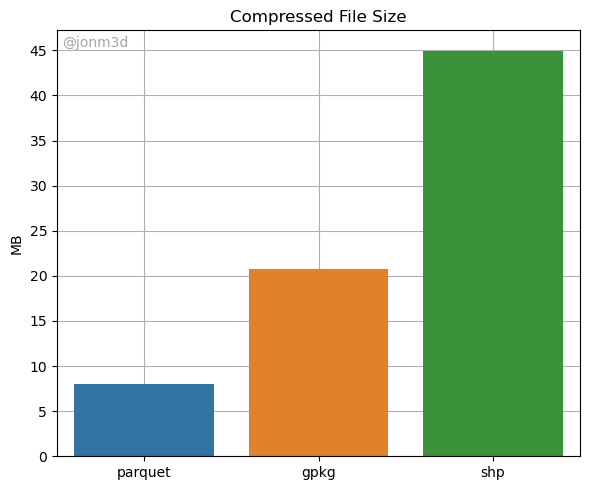

In [10]:
def get_file_size(file_path):
    size = os.path.getsize(file_path) / 1024 / 1024  # Convert to MB
    if file_path.endswith('.shp'):
        # For Shapefiles, also account for .shx, .dbf and any other potential sidecar files
        base_path = file_path[:-4]  # remove .shp extension
        for ext in ['.shx', '.dbf', '.prj', '.sbn', '.sbx', '.cpg']:
            sidecar_file = base_path + ext
            if os.path.exists(sidecar_file):
                size += os.path.getsize(sidecar_file) / 1024 / 1024
    return size


parquet_file_size = get_file_size(os.path.join(bench_dir, 'test.parquet'))
gpkg_file_size = get_file_size(os.path.join(bench_dir, 'test.gpkg'))
shp_file_size = get_file_size(os.path.join(bench_dir, 'test.shp'))
# fgb_file_size = get_file_size(os.path.join(bench_dir, 'test.fgb'))

# Create DataFrame to store results
size_results = {
    'Format': ['parquet', 'gpkg', 'shp'],
    'MB': [parquet_file_size, gpkg_file_size, shp_file_size] #, fgb_file_size]
}
size_df = pd.DataFrame(size_results)

plt.figure(figsize=(6, 5))
ax = sns.barplot(x='Format', y='MB', data=size_df, zorder=2)

plt.annotate('@jonm3d',
             xy=(0.01, 0.96), 
             xycoords='axes fraction',
             fontsize=10, 
             alpha=0.7,
             color='grey')

plt.grid(zorder=1)

# Setting integer only y-axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Compressed File Size')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(bench_dir, 'size_results.png'))


Let's make sure the data we read in both ways is actually the same and there wasn't some error.

In [7]:
def compare_geodataframes(gdf1, gdf2):
    # Check shape
    if gdf1.shape != gdf2.shape:
        return False

    # Check geometry equality
    if not gdf1.geometry.equals(gdf2.geometry):
        return False
    
    # Compare time columns if present
    if "time" in gdf1.columns and "time" in gdf2.columns:
        # Check if either geodataframe has time in datetime format
        if isinstance(gdf1["time"].iloc[0], pd.Timestamp):
            time1 = gdf1["time"].dt.strftime('%Y-%m-%d %H:%M:%S')
        else:
            time1 = gdf1["time"]

        if isinstance(gdf2["time"].iloc[0], pd.Timestamp):
            time2 = gdf2["time"].dt.strftime('%Y-%m-%d %H:%M:%S')
        else:
            time2 = gdf2["time"]

        if not (time1 == time2).all():
            print("Discrepancy found in the time column")
            return False

    # Check attribute data equality ignoring the column names
    for col_gdf1, col_gdf2 in zip(gdf1.drop(columns=["geometry", "time"]).columns, gdf2.drop(columns=["geometry", "time"]).columns):
        # Using numpy's isclose method to compare column values, considering floating point inaccuracies
        if not np.isclose(gdf1[col_gdf1], gdf2[col_gdf2], equal_nan=True).all():
            print(f"Discrepancy found in column: {col_gdf1}")
            return False

    return True



# Read data from each format into separate geodataframes
print("Reading test data...")
gdf_parquet = gpd.read_parquet(os.path.join(bench_dir, 'test.parquet'))
gdf_gpkg = gpd.read_file(os.path.join(bench_dir, 'test.gpkg'), engine="pyogrio")
gdf_shp = gpd.read_file(os.path.join(bench_dir, 'test.shp'), engine="pyogrio")
# gdf_fgb = gpd.read_file(os.path.join(bench_dir, 'test.fgb'), engine="pyogrio")

# We will compare all geodataframes with the parquet file as reference
gdfs = {
    'GeoPackage': gdf_gpkg,
    'Shapefile': gdf_shp,
    # 'FlatGeobuf': gdf_fgb
}

for name, gdf in gdfs.items():
    are_equal = compare_geodataframes(gdf_parquet, gdf)
    if are_equal:
        print(f'The data in the {name} file matches the Parquet data!')
    else:
        print(f'Something went wrong; the data in the {name} file is different now.')


Reading test data...
The data in the GeoPackage file matches the Parquet data!
The data in the Shapefile file matches the Parquet data!


If you need to use GeoPackage, be sure to use the pyogrio engine! Otherwise use Parquet wherever read/write speed or compressed size matters most.